### Inspect

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch

def extract_field(data, field):
    return [x[field] for x in data]

def extract_layer(data, layer):
    return np.array([x[layer] for x in data])

class DotDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def process_apical_activity(stim_evoked, reactivation, eta):
    teaching_signal = (reactivation - stim_evoked)
    return stim_evoked + (eta * teaching_signal)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

/home/sanderdh/miniconda3/envs/dfc_environment/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
with open('/home/sanderdh/dfc/dfc/out/run_2024-06-26_11-14-51/inspect.pkl', 'rb') as fp:
    data_bp = pickle.load(fp)
with open('/home/sanderdh/dfc/dfc/out/traj_tp_0&1_100steps_goodresults/inspect.pkl', 'rb') as fp:
    data_tp = pickle.load(fp)

## Create arrays from simulation data

In [3]:
s0 = DotDict() # MNIST digit 5
s1 = DotDict() # MNIST digit 8

for s in [s0,s1]:
    s.stim_evoked_bp = [[],[],[]]
    s.reactivation_bp = [[],[],[]]
    s.stim_evoked_tp = [[],[],[]]
    s.reactivation_tp = [[],[],[]]

stop = 68

# Backprop data
for i_data in range(np.min([stop,len(data_bp)-1])):
    y = data_bp[i_data]['y'].detach().cpu().numpy()
    
    for b_idx in [0,1]:
        s = s0 if y[b_idx] == 0 else s1

        for layer in [0,1,2]:
            s.stim_evoked_bp[layer].append(data_bp[i_data]['r_ff'][layer][b_idx])
            s.reactivation_bp[layer].append(data_bp[i_data]['r'][layer][b_idx]) # TODO: calculate with Pau's formula

# Targetprop data
for i_data in range(np.min([stop,len(data_tp)-1])):
    y = data_tp[i_data]['y'].detach().cpu().numpy()
    
    for b_idx in [0,1]:
        s = s0 if y[b_idx][0] > 0.5 else s1

        for layer in [0,1,2]:
            s.stim_evoked_tp[layer].append(data_tp[i_data]['r_ff'][layer][b_idx])
            s.reactivation_tp[layer].append(data_tp[i_data]['r'][layer][b_idx])

# Turn lists into arrays
for layer in [0,1,2]:
    for s in [s0,s1]:
        s.stim_evoked_bp[layer] = np.array(s.stim_evoked_bp[layer])
        s.reactivation_bp[layer] = np.array(s.reactivation_bp[layer])

        # s.reactivation_bp[layer] = process_apical_activity(s.stim_evoked_bp[layer], s.reactivation_bp[layer], eta=2)

        s.stim_evoked_tp[layer] = np.array(s.stim_evoked_tp[layer])
        s.reactivation_tp[layer] = np.array(s.reactivation_tp[layer])

In [4]:
s.stim_evoked_bp[layer]

array([[0.6764036 , 0.        , 0.40122306, ..., 0.7121663 , 0.        ,
        0.52903205],
       [0.67567796, 0.        , 0.387505  , ..., 0.7004245 , 0.        ,
        0.5139599 ],
       [0.6624308 , 0.        , 0.3784507 , ..., 0.69514424, 0.        ,
        0.49314514],
       ...,
       [1.2740247 , 0.        , 0.5805699 , ..., 0.64918756, 0.5074292 ,
        0.95042413],
       [1.2701707 , 0.        , 0.5800243 , ..., 0.6481686 , 0.5091323 ,
        0.9476262 ],
       [1.3254    , 0.        , 0.6056063 , ..., 0.6235331 , 0.5599392 ,
        0.99539685]], dtype=float32)

In [5]:
s.reactivation_bp[layer]

array([[0.68412644, 0.        , 0.40661356, ..., 0.7112867 , 0.        ,
        0.53254765],
       [0.68376833, 0.        , 0.3928935 , ..., 0.69953704, 0.        ,
        0.51741135],
       [0.6706276 , 0.        , 0.3839283 , ..., 0.6942016 , 0.        ,
        0.49652708],
       ...,
       [1.27596   , 0.        , 0.5814023 , ..., 0.64915824, 0.5081055 ,
        0.9513668 ],
       [1.2721418 , 0.        , 0.5808706 , ..., 0.6481393 , 0.50982666,
        0.9485778 ],
       [1.326978  , 0.        , 0.60628283, ..., 0.62351334, 0.5605245 ,
        0.9961643 ]], dtype=float32)

## Define early and late trails + define projections and similarities

In [6]:
n_early_late = 3
start = 0

for s in [s0,s1]:
    s.early_trails_bp = [[],[],[]]
    s.late_trails_bp = [[],[],[]]
    s.early_trails_tp = [[],[],[]]
    s.late_trails_tp = [[],[],[]]

# Calculate early and late trails
for s in [s0,s1]:
    for layer in [0,1,2]:
        s.early_trails_bp[layer] = np.average(s.stim_evoked_bp[layer][start:start+n_early_late,:], axis=0)
        s.late_trails_bp[layer] = np.average(s.stim_evoked_bp[layer][-n_early_late:,:], axis=0)
        s.early_trails_tp[layer] = np.average(s.stim_evoked_tp[layer][start:start+n_early_late,:], axis=0)
        s.late_trails_tp[layer] = np.average(s.stim_evoked_tp[layer][-n_early_late:,:], axis=0)

## Orthogonal PC

In [7]:
for s in [s0, s1]:
    s.pca_bp = [PCA(n_components=1), PCA(n_components=1), PCA(n_components=1)]
    s.pca_tp = [PCA(n_components=1), PCA(n_components=1), PCA(n_components=1)]

    s.proj_stim_evoked_bp = [[],[],[]]
    s.proj_reactivation_bp = [[],[],[]]
    s.proj_stim_evoked_tp = [[],[],[]]
    s.proj_reactivation_tp = [[],[],[]]

    s.pc_stim_evoked_bp = [[],[],[]]
    s.pc_reactivation_bp = [[],[],[]]
    s.pc_stim_evoked_tp = [[],[],[]]
    s.pc_reactivation_tp = [[],[],[]]

for s in [s0, s1]:
    for layer in [0,1,2]:
        # BP
        early_to_late_bp = s.late_trails_bp[layer] - s.early_trails_bp[layer]

        stim_centered_bp = s.stim_evoked_bp[layer] - s.early_trails_bp[layer]
        react_centered_bp = s.reactivation_bp[layer] - s.early_trails_bp[layer]

        s.proj_stim_evoked_bp[layer] = np.dot(stim_centered_bp, early_to_late_bp) / np.square(np.linalg.norm(early_to_late_bp))
        s.proj_reactivation_bp[layer] = np.dot(react_centered_bp, early_to_late_bp) / np.square(np.linalg.norm(early_to_late_bp))
        
        residuals_stim_bp = stim_centered_bp - np.outer(s.proj_stim_evoked_bp[layer], early_to_late_bp)
        residuals_react_bp = react_centered_bp - np.outer(s.proj_reactivation_bp[layer], early_to_late_bp)

        s.pca_bp[layer].fit(np.concatenate([residuals_stim_bp]))
        s.pc_stim_evoked_bp[layer] = s.pca_bp[layer].transform(residuals_stim_bp)
        s.pc_reactivation_bp[layer] = s.pca_bp[layer].transform(residuals_react_bp)

        # TP
        early_to_late_tp = s.late_trails_tp[layer] - s.early_trails_tp[layer]

        stim_centered_tp = s.stim_evoked_tp[layer] - s.early_trails_tp[layer]
        react_centered_tp = s.reactivation_tp[layer] - s.early_trails_tp[layer]

        s.proj_stim_evoked_tp[layer] = np.dot(stim_centered_tp, early_to_late_tp) / np.square(np.linalg.norm(early_to_late_tp))
        s.proj_reactivation_tp[layer] = np.dot(react_centered_tp, early_to_late_tp) / np.square(np.linalg.norm(early_to_late_tp))
        
        residuals_stim_tp = stim_centered_tp - np.outer(s.proj_stim_evoked_tp[layer], early_to_late_tp)
        residuals_react_tp = react_centered_tp - np.outer(s.proj_reactivation_tp[layer], early_to_late_tp)

        s.pca_tp[layer].fit(np.concatenate([residuals_stim_tp]))
        s.pc_stim_evoked_tp[layer] = s.pca_tp[layer].transform(residuals_stim_tp)
        s.pc_reactivation_tp[layer] = s.pca_tp[layer].transform(residuals_react_tp)

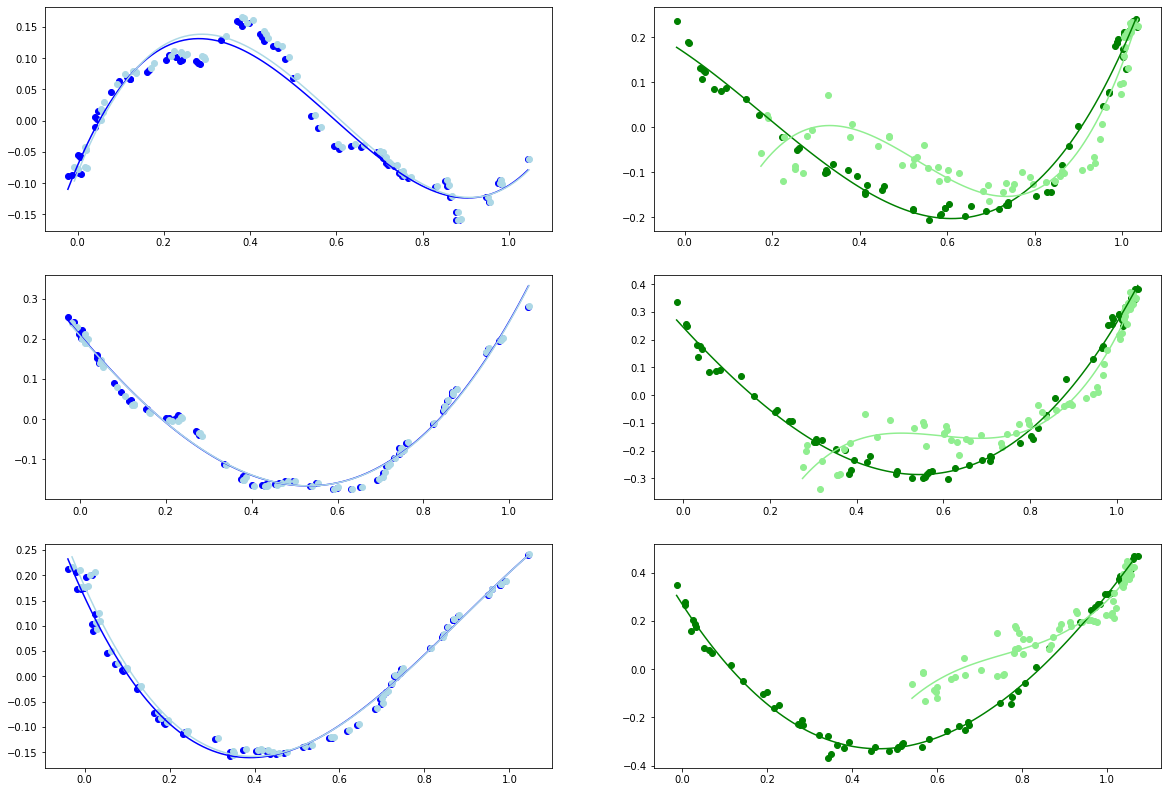

In [8]:
alpha = 1
linewidth=4
window = 3
s = s1

_, axs = plt.subplots(3, 2, figsize=(20,14))

for layer in [0,1,2]:
    # Lines
    degree = 3
    coeff, cov = np.polyfit(s.proj_stim_evoked_bp[layer], s.pc_stim_evoked_bp[layer], degree, cov=True)
    xx = np.linspace(np.min(s.proj_stim_evoked_bp[layer]), np.max(s.proj_stim_evoked_bp[layer]), 100)
    yy = np.polyval(coeff, xx)

    axs[layer][0].plot(xx, yy, color='blue', label='Stimulus')

    coeff, cov = np.polyfit(s.proj_reactivation_bp[layer], s.pc_reactivation_bp[layer], degree, cov=True)
    xx = np.linspace(np.min(s.proj_reactivation_bp[layer]), np.max(s.proj_reactivation_bp[layer]), 100)
    yy = np.polyval(coeff, xx)

    axs[layer][0].plot(xx, yy, color='lightblue', label='Reactivation')
    axs[layer][0].scatter(s.proj_stim_evoked_bp[layer], s.pc_stim_evoked_bp[layer], c='blue', alpha=alpha)
    axs[layer][0].scatter(s.proj_reactivation_bp[layer], s.pc_reactivation_bp[layer], c='lightblue', alpha=alpha)
    
    coeff, cov = np.polyfit(s.proj_stim_evoked_tp[layer], s.pc_stim_evoked_tp[layer], degree, cov=True)
    xx = np.linspace(np.min(s.proj_stim_evoked_tp[layer]), np.max(s.proj_stim_evoked_tp[layer]), 100)
    yy = np.polyval(coeff, xx)

    axs[layer][1].plot(xx, yy, color='green', label='Stimulus')

    coeff, cov = np.polyfit(s.proj_reactivation_tp[layer], s.pc_reactivation_tp[layer], degree, cov=True)
    xx = np.linspace(np.min(s.proj_reactivation_tp[layer]), np.max(s.proj_reactivation_tp[layer]), 100)
    yy = np.polyval(coeff, xx)

    axs[layer][1].plot(xx, yy, color='lightgreen', label='Reactivation')
    axs[layer][1].scatter(s.proj_stim_evoked_tp[layer], s.pc_stim_evoked_tp[layer], c='green', alpha=alpha)
    axs[layer][1].scatter(s.proj_reactivation_tp[layer], s.pc_reactivation_tp[layer], c='lightgreen', alpha=alpha)

plt.savefig(f'figs/orthogonal_pca_trajectories.svg', format='svg', bbox_inches="tight")

## Angles

In [12]:
for s in [s0, s1]:
    s.cos_stim_evoked_bp = [[],[],[]]
    s.cos_reactivation_bp = [[],[],[]]
    s.cos_stim_evoked_tp = [[],[],[]]
    s.cos_reactivation_tp = [[],[],[]]

for s in [s0, s1]:
    for layer in [0,1,2]:
        s.cos_stim_evoked_bp[layer] = np.array([cos_sim(v, s.late_trails_bp[layer]) for v in s.stim_evoked_bp[layer]])
        s.cos_reactivation_bp[layer] = np.array([cos_sim(v, s.late_trails_bp[layer]) for v in s.reactivation_bp[layer]])

        s.cos_stim_evoked_tp[layer] = np.array([cos_sim(v, s.late_trails_tp[layer]) for v in s.stim_evoked_tp[layer]])
        s.cos_reactivation_tp[layer] = np.array([cos_sim(v, s.late_trails_tp[layer]) for v in s.reactivation_tp[layer]])

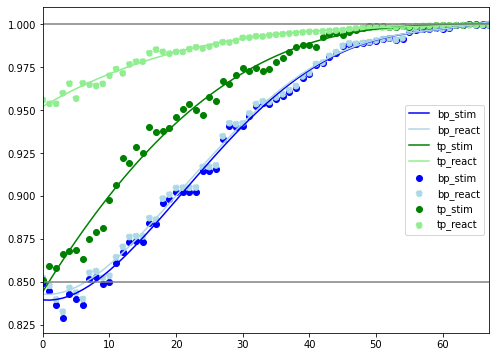

In [13]:
fig, _ = plt.subplots(figsize=(8,6))

xx = range(len(s.cos_stim_evoked_bp[layer]))
degree = 4

coeff, cov = np.polyfit(xx, s.cos_stim_evoked_bp[layer], degree, cov=True)
yy_bp_stim = np.polyval(coeff, xx)
coeff, cov = np.polyfit(xx, s.cos_reactivation_bp[layer], degree, cov=True)
yy_bp_react = np.polyval(coeff, xx)
coeff, cov = np.polyfit(xx, s.cos_stim_evoked_tp[layer], degree, cov=True)
yy_tp_stim = np.polyval(coeff, xx)
coeff, cov = np.polyfit(xx, s.cos_reactivation_tp[layer], degree, cov=True)
yy_tp_react = np.polyval(coeff, xx)

plt.plot(xx, yy_bp_stim, color='blue', label='bp_stim')
plt.plot(xx, yy_bp_react, color='lightblue', label='bp_react')

plt.plot(xx, yy_tp_stim, color='green', label='tp_stim')
plt.plot(xx, yy_tp_react, color='lightgreen', label='tp_react')

plt.scatter(xx, s.cos_stim_evoked_bp[layer], label='bp_stim', c='blue')
plt.scatter(xx, s.cos_reactivation_bp[layer], label='bp_react', linestyle='--', c='lightblue')

plt.scatter(xx, s.cos_stim_evoked_tp[layer], label='tp_stim', c='green')
plt.scatter(xx, s.cos_reactivation_tp[layer], label='tp_react', linestyle='--', c='lightgreen')

plt.axhline(y=0.85, color='grey', linestyle='-')
plt.axhline(y=1, color='grey', linestyle='-')

plt.xlim(0,stop-1)
plt.yscale('linear')
plt.legend()

plt.savefig(f'figs/angles_to_late.svg', format='svg', bbox_inches="tight")